Vocabulary: [' ', 'd', 'e', 'h', 'l', 'o', 'r', 'w']

--- Starting Training ---
Epoch 1/1000
Epoch 2/1000
Epoch 3/1000
Epoch 4/1000
Epoch 5/1000
Epoch 6/1000
Epoch 7/1000
Epoch 8/1000
Epoch 9/1000
Epoch 10/1000
Epoch 11/1000
Epoch 12/1000
Epoch 13/1000
Epoch 14/1000
Epoch 15/1000
Epoch 16/1000
Epoch 17/1000
Epoch 18/1000
Epoch 19/1000
Epoch 20/1000
Epoch 21/1000
Epoch 22/1000
Epoch 23/1000
Epoch 24/1000
Epoch 25/1000
Epoch 26/1000
Epoch 27/1000
Epoch 28/1000
Epoch 29/1000
Epoch 30/1000
Epoch 31/1000
Epoch 32/1000
Epoch 33/1000
Epoch 34/1000
Epoch 35/1000
Epoch 36/1000
Epoch 37/1000
Epoch 38/1000
Epoch 39/1000
Epoch 40/1000
Epoch 41/1000
Epoch 42/1000
Epoch 43/1000
Epoch 44/1000
Epoch 45/1000
Epoch 46/1000
Epoch 47/1000
Epoch 48/1000
Epoch 49/1000
Epoch 50/1000
Epoch 51/1000
Epoch 52/1000
Epoch 53/1000
Epoch 54/1000
Epoch 55/1000
Epoch 56/1000
Epoch 57/1000
Epoch 58/1000
Epoch 59/1000
Epoch 60/1000
Epoch 61/1000
Epoch 62/1000
Epoch 63/1000
Epoch 64/1000
Epoch 65/1000
Epoch 66/1000
Epoch

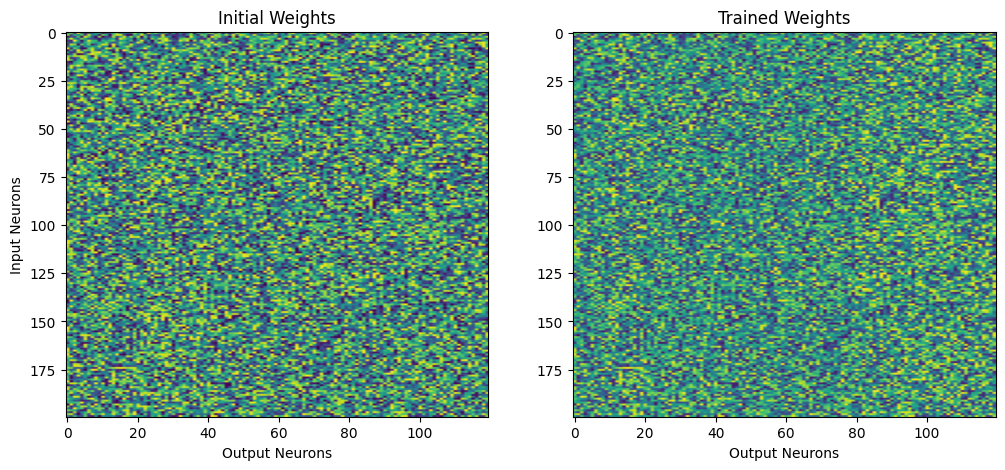


--- Calibrating Readout Neurons ---
Character ' ' is most strongly represented by neuron 66
Character 'd' is most strongly represented by neuron 174
Character 'e' did not cause any output spikes.
Character 'h' did not cause any output spikes.
Character 'l' did not cause any output spikes.
Character 'o' did not cause any output spikes.
Character 'r' is most strongly represented by neuron 7
Character 'w' did not cause any output spikes.

--- Making a Prediction ---
Prompt: 'h'
No output spikes generated for the prompt.
Model predicts next character is: '?'


In [7]:
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import spikegen
import matplotlib.pyplot as plt
import numpy as np

# ---- 1. Simulation and Network Parameters ----
num_steps = 100          # Simulation duration for each character
batch_size = 1
dtype = torch.float

# -- Network Architecture
num_inputs = 120         # 12 unique chars * 10 neurons/char
num_hidden = 200         # Number of neurons in the processing layer
num_outputs = num_hidden # Output is the activity of the hidden layer

# -- Neuron Parameters (LIF)
beta = 0.9               # Membrane potential decay rate
thresh = 0.8             # Neuron firing threshold

# -- STDP Parameters
tau_pre = 20e-3          # Pre-synaptic trace time constant
tau_post = 20e-3         # Post-synaptic trace time constant
g_pre = 1e-2             # STDP learning rate (potentiation)
g_post = 1.05 * g_pre    # STDP learning rate (depression)

# ---- 2. Prepare Data and Encoding ----
text = "hello world"
vocab = sorted(list(set(text)))
char_to_int = {char: i for i, char in enumerate(vocab)}
int_to_char = {i: char for i, char in enumerate(vocab)}
print(f"Vocabulary: {vocab}")

neurons_per_char = 10

def encode_char_to_spikes(char):
    """Encodes a single character into a spike train using population coding."""
    char_idx = char_to_int[char]
    spike_data = torch.zeros(num_steps, num_inputs, dtype=dtype)
    start_neuron = char_idx * neurons_per_char
    end_neuron = start_neuron + neurons_per_char
    
    # Generate a burst of spikes for the corresponding neuron group
    spikes = (torch.rand(num_steps, neurons_per_char) > 0.5).float()
    spike_data[:, start_neuron:end_neuron] = spikes
    return spike_data

# ---- 3. Define the Network ----
class SNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta, threshold=thresh, learn_beta=False)

    def forward(self, x):
        # Initialize hidden states at t=0
        mem = self.lif1.init_leaky()

        # Record outputs
        spk_out = []
        mem_out = []

        # Time-step loop
        for step in range(num_steps):
            cur1 = self.fc1(x[step])
            spk1, mem = self.lif1(cur1, mem)
            spk_out.append(spk1)
            mem_out.append(mem)

        return torch.stack(spk_out), torch.stack(mem_out)

# Instantiate the network
net = SNN().to("cpu")

# ---- 4. STDP Learning Rule (CORRECTED) ----
def stdp_update(weights, pre_spikes, post_spikes):
    """Applies a trace-based STDP update to the weights."""
    with torch.no_grad():
        # Calculate pre- and post-synaptic traces
        pre_trace = torch.zeros(num_inputs, dtype=dtype)
        post_trace = torch.zeros(num_hidden, dtype=dtype)
        
        # Convert time constants to decay factors
        alpha = float(np.exp(-1/tau_pre))
        gamma = float(np.exp(-1/tau_post))

        for step in range(num_steps):
            pre_trace = pre_trace * alpha + pre_spikes[step]
            post_trace = post_trace * gamma + post_spikes[step]

            # Potentiation (strengthening)
            # Use torch.outer to get the correct [200, 120] shape.
            potentiation = g_pre * torch.outer(post_spikes[step], pre_trace)
            weights += potentiation
            
            # Depression (weakening)
            depression = g_post * torch.outer(post_trace, pre_spikes[step])
            weights -= depression


# ---- 5. Training Loop ----
print("\n--- Starting Training ---")
num_epochs = 1000

# Plot initial weights
initial_weights = net.fc1.weight.data.clone().cpu().numpy()

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    # Process the text character by character
    for i in range(len(text) - 1):
        input_char = text[i]
        
        # Get input spikes
        input_spikes = encode_char_to_spikes(input_char)
        
        # Run the network
        spk_out, _ = net(input_spikes)
        
        # Apply STDP
        stdp_update(net.fc1.weight.data, input_spikes, spk_out)

print("--- Training Complete ---")

# Plot final weights
trained_weights = net.fc1.weight.data.clone().cpu().numpy()

# ---- 6. Visualization & Prediction ----
# Visualize weights
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(initial_weights, cmap='viridis', aspect='auto')
ax1.set_title('Initial Weights')
ax1.set_xlabel('Output Neurons')
ax1.set_ylabel('Input Neurons')

ax2.imshow(trained_weights, cmap='viridis', aspect='auto')
ax2.set_title('Trained Weights')
ax2.set_xlabel('Output Neurons')
plt.show()


# -- Prediction via Readout Calibration
print("\n--- Calibrating Readout Neurons ---")
readout_map = {}
# Find which output neurons respond most strongly to each character
for char in vocab:
    input_spikes = encode_char_to_spikes(char)
    spk_out, _ = net(input_spikes)
    total_spikes_per_neuron = torch.sum(spk_out, dim=0)
    # Check if any neuron spiked at all
    if total_spikes_per_neuron.sum() > 0:
        most_active_neuron = torch.argmax(total_spikes_per_neuron).item()
        readout_map[most_active_neuron] = char
        print(f"Character '{char}' is most strongly represented by neuron {most_active_neuron}")
    else:
        print(f"Character '{char}' did not cause any output spikes.")


# -- Make a Prediction
print("\n--- Making a Prediction ---")
prompt_char = 'h'
print(f"Prompt: '{prompt_char}'")

# Present the character and get the output spike pattern
input_spikes = encode_char_to_spikes(prompt_char)
spk_out, _ = net(input_spikes)

# Get the most active output neuron
predicted_char = '?'
if spk_out.sum() > 0:
    total_spikes_per_neuron = torch.sum(spk_out, dim=0)
    predicted_neuron_idx = torch.argmax(total_spikes_per_neuron).item()
    predicted_char = readout_map.get(predicted_neuron_idx, "?")
else:
    print("No output spikes generated for the prompt.")

print(f"Model predicts next character is: '{predicted_char}'")

In [ ]:
import numpy
import matplotlib.pyplot as plt

# 1. Parameters
num_steps = 100

# Architecture
num_inputs = 120
num_middle = 160
num_hidden = 200
num_outputs = num_hidden

# Neuron parameters
beta = 0.9
thresh = 0.8

# STDP parameters
tau_pre = 20e-3
tau_post = 20e-3
g_pre = 1e-2
g_post = 1.05 * g_pre

# Prepare data encoding
text = "hello world"
vocab = sorted(list(set(text)))
char_to_int = {char: i for i, char in enumerate(vocab)}
int_to_char = {i: char for i, char in enumerate(vocat)}
print(f"Vocabulary: {vocab}")

neurons_per_char = 10
def encode_char_to_spikes(char):
    char_idx = char_to_int[char]
    spike_data = np.zeros(num_steps, num_inputs)

    start_neuron = char_idx * neurons_per_char
    end_neuron = start_neuron + neurons_per_char

    # burst the neuron group
    spikes = (torch.rand)